# Simulating the 100 Prisoners Riddle


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/100_prisoners_problem_qtl1.svg/1920px-100_prisoners_problem_qtl1.svg.png" alt="Girl in a jacket" width="400" height="300">

A prison director offers a last chance to 100 death row inmates numbered from 1 to 100.
- A cupboard with 100 drawers can be found in a room.
- The director places one prisoner's number at random in each closed drawer.

- The convicts enter the chamber one by one. Each prisoner is allowed to access and examine 50 drawers in any order. The drawers are then closed again.

1. Every prisoner discovers their number in one of the drawers, and all convicts are pardoned.
2. If even one prisoner fails to locate their number, all inmates perish.

The convicts may talk strategy before the first prisoner enters the room, but they may not communicate once the first prisoner enters to look in the drawers. What is the best tactic for the inmates?

In [1]:
import pandas as pd
import numpy as np
from tqdm import trange
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
color_pal = sns.color_palette(n_colors=50)

In [2]:
def shuffle_boxes():
    prisoner_numbers = [x for x in range(0, 100)]
    boxes = {}
    np.random.shuffle(prisoner_numbers)
    for i, p in enumerate(prisoner_numbers):
        boxes[i] = p
    return boxes


PRISONERS = [x for x in range(0, 100)]
BOX_NUMBERS = [x for x in range(0, 100)]

# Random choice strategy

In [3]:
def random_strategy(prisoner_number, boxes):
    """
    Randomly select 50 boxes for the prisoner.

    Returns True if they found their number, False if they did not
    """
    prisoner_choices = np.random.choice(BOX_NUMBERS, size=50, replace=False)
    for choice in prisoner_choices:
        if boxes[choice] == prisoner_number:
            return True
    return False

## Simulate the strategy

In [4]:
results = {}
for sim in trange(5_000):
    boxes = shuffle_boxes()
    n_correct = 0
    for prisoner in PRISONERS:
        correct = random_strategy(prisoner_number=prisoner, boxes=boxes)
        if correct:
            n_correct += 1
    results[sim] = n_correct

100%|██████████| 5000/5000 [00:30<00:00, 163.31it/s]


In [5]:
# Create Dataframe with results
results_random = pd.DataFrame.from_dict(results, orient="index", columns=["ncorrect"])

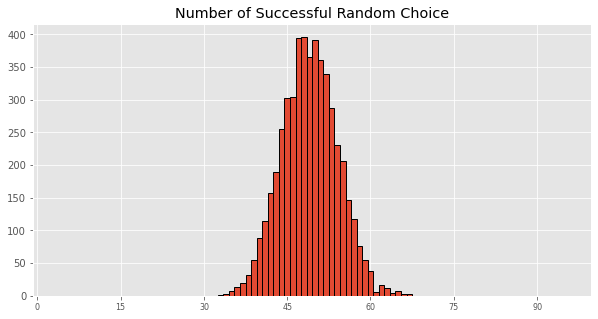

In [6]:
results_agg = pd.DataFrame(index=range(1, 101))
results_agg["counts"] = results_agg.index.map(
    results_random["ncorrect"].value_counts().to_dict()
).fillna(0)

ax = results_agg.plot(
    kind="bar",
    figsize=(10, 5),
    width=1,
    lw=1,
    edgecolor="black",
    title="Number of Successful Random Choice",
)

ax.set_xticklabels(ax.get_xticks(), rotation=0, size=8)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
ax.legend().remove()

plt.show()

In [7]:
# Odds of success
(0.5) ** 100

7.888609052210118e-31

In [8]:
0.00000000000000000000000000000078

7.8e-31

# Loop Strategy
- Start with the box that's their own number
- Select the next box based on the number in the last chosen box

In [9]:
def loop_strategy(prisoner_number, boxes):
    """
    Select 50 boxes starting with their own number,
    next selecting the results from the last box and so on.

    Returns True if they found their number, False if they did not
    """
    next_box = prisoner_number
    for x in range(50):
        if boxes[next_box] == prisoner_number:
            return True
        next_box = boxes[next_box]
    return False

In [10]:
def try_strategy(boxes, strategy):
    n_correct = 0
    for prisoner in PRISONERS:
        correct = strategy(prisoner_number=prisoner, boxes=boxes)
        if correct:
            n_correct += 1
    return n_correct

In [11]:
results = {}
for sim in trange(5_000):
    boxes = shuffle_boxes()
    n_correct = 0
    for prisoner in PRISONERS:
        correct = loop_strategy(prisoner_number=prisoner, boxes=boxes)
        if correct:
            n_correct += 1
    results[sim] = n_correct
# Create Dataframe with results
results_loop = pd.DataFrame.from_dict(results, orient="index", columns=["ncorrect"])

100%|██████████| 5000/5000 [00:03<00:00, 1332.11it/s]


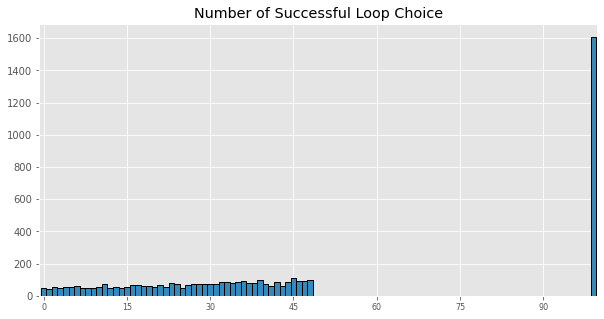

In [12]:
results_agg = pd.DataFrame(index=range(0, 100))
results_agg.index += 1

results_agg["counts"] = results_agg.index.map(
    results_loop["ncorrect"].value_counts().to_dict()
).fillna(0)

ax = results_agg.plot(
    kind="bar",
    color=color_pal[1],
    figsize=(10, 5),
    width=1,
    lw=1,
    edgecolor="black",
    title="Number of Successful Loop Choice",
)

ax.set_xticklabels(ax.get_xticks(), rotation=0, size=8)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
ax.legend().remove()

plt.show()

In [13]:
(results_loop["ncorrect"] == 100).mean()

0.3216

# How does it function?
- The boxes are "connected" to one another.
- Consider this as a graph network, with the boxes as nodes and the paper as edges.
- There can be any number of "loops" in the graph.
- The prisoner is guaranteed to be in their own loop by starting with their own number.
- If the graph's greatest "loop" is smaller than 50, all convicts will succeed!

In [14]:
boxes = shuffle_boxes()
G = nx.DiGraph()
G.add_nodes_from(PRISONERS)

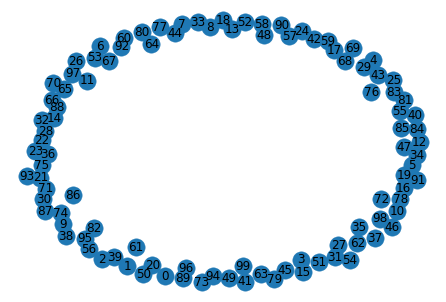

In [15]:
nx.draw(G, with_labels=True)
plt.show()

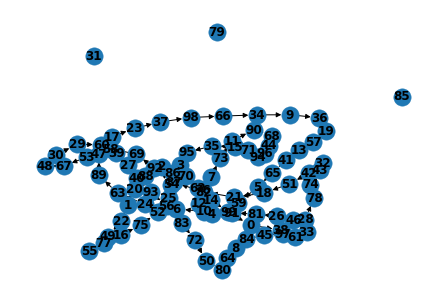

In [16]:
edges = [(x, y) for x, y in boxes.items()]
G.add_edges_from(edges, weight=1)
nx.draw(G, with_labels=True, font_weight="bold")

## Coloring The loops

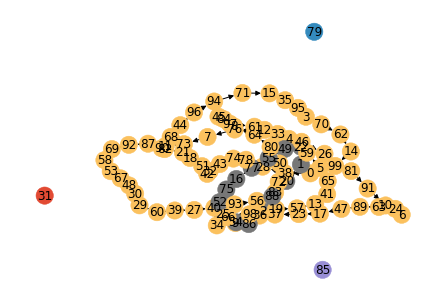

In [17]:
node_loop = {}
loops = nx.simple_cycles(G)

for loop, nodes in enumerate(loops):
    for node in nodes:
        node_loop[node] = loop
loop_df = pd.DataFrame.from_dict(node_loop, orient="index", columns=["loop"])

loop_df["color"] = loop_df["loop"].apply(lambda x: color_pal[x])
loop_df = loop_df.sort_index()

pos = None
# pos = nx.layout.fruchterman_reingold_layout(G)
# pos = nx.layout.kamada_kawai_layout(G)
nx.draw(G, pos, node_color=loop_df["color"].values, with_labels=True)
plt.show()

In [18]:
largest_loop = loop_df['loop'].value_counts().max()
print(f'Largest loop is size {largest_loop}')

Largest loop is size 83


In [19]:
# Add colors to node
loops = nx.simple_cycles(G)
for node, loop in loop_df["loop"].to_dict().items():
    G.nodes[node]["loop"] = str(loop)
    G.nodes[node]["label"] = node

# Create Graph from Boxes

In [20]:
def create_graph(boxes):
    G = nx.DiGraph()
    G.add_nodes_from(PRISONERS)
    edges = [(x, y) for x, y in boxes.items()]
    G.add_edges_from(edges, weight=1)
    node_loop = {}
    loops = nx.simple_cycles(G)

    for loop, nodes in enumerate(loops):
        for node in nodes:
            node_loop[node] = loop
    loop_df = pd.DataFrame.from_dict(node_loop, orient="index", columns=["loop"])

    loop_df["color"] = loop_df["loop"].apply(lambda x: color_pal[x])
    loop_df = loop_df.sort_index()
    # Add colors to node
    for node, loop in loop_df["loop"].to_dict().items():
        G.nodes[node]["group"] = str(loop)
        G.nodes[node]["loop_key"] = loop
        G.nodes[node]["label"] = str(node)
    return G, loop_df

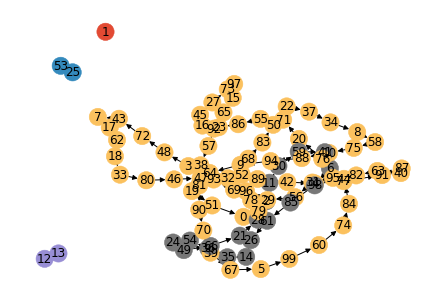

In [21]:
boxes = shuffle_boxes()
G, loop_df = create_graph(boxes)
nx.draw(G, with_labels=True, node_color=loop_df["color"].values)

# Interactive Graph with pyvis

In [22]:
!pip install pyvis -q

In [23]:
from pyvis.network import Network

boxes = shuffle_boxes()
G, loop_df = create_graph(boxes)

net = Network(notebook=True, height=500, width=1000, directed=True)
net.from_nx(G)
net.show("example.html")

In [24]:
boxes = shuffle_boxes()
G, loop_df = create_graph(boxes)

longest_loop = loop_df["loop"].value_counts().max()
npassed_random = try_strategy(boxes, random_strategy)
npassed_loop = try_strategy(boxes, loop_strategy)

print(f"Longest Loop {longest_loop}")
print(f"Random: {npassed_random}")
print(f"Loop: {npassed_loop}")

net = Network(notebook=True, height=500, width=1000, directed=True)
net.from_nx(G)
net.show("example.html")

Longest Loop 42
Random: 47
Loop: 100


# Simluate the Longest Loop

In [25]:
longest_loops = []
for x in trange(5_000):
    boxes = shuffle_boxes()
    G, loop_df = create_graph(boxes)
    longest_loop = loop_df["loop"].value_counts().max()
    longest_loops.append(longest_loop)

100%|██████████| 5000/5000 [00:44<00:00, 113.20it/s]


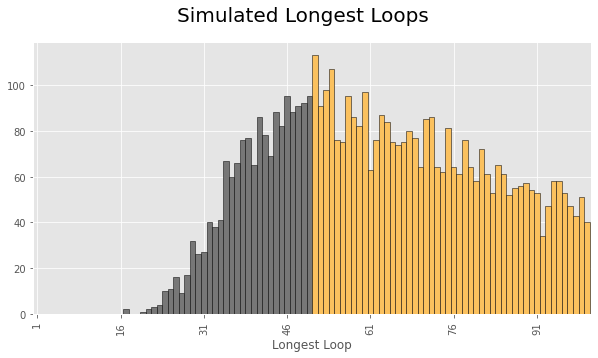

In [26]:
longest_loop_df = pd.DataFrame(index=range(1, 101))
longest_loop_df["count"] = longest_loop_df.index.map(
    pd.Series(longest_loops).value_counts().to_dict()
).fillna(0)

fig, ax = plt.subplots(figsize=(10, 5))

success = longest_loop_df.copy()
success.loc[success.index > 50, "count"] = 0
success.plot(kind="bar", color=color_pal[3], width=1, edgecolor="black", ax=ax)

fail = longest_loop_df.copy()
fail.loc[fail.index <= 50, "count"] = 0
fail.plot(kind="bar", color=color_pal[4], width=1, edgecolor="black", ax=ax)

plt.xlabel("Longest Loop")
fig.suptitle("Simulated Longest Loops", fontsize=20)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.legend().remove()
plt.show()